In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jaxquantum as jqt
import jaxquantum.circuits as jqtc
from jax import jit, grad
import jax.numpy as jnp
from math import prod
import matplotlib.pyplot as plt

from tqdm import tqdm

import jax
import optax
import functools

In [3]:
def MX_plus():

    g = jqt.basis(2,0)
    e = jqt.basis(2,1)
    plus = (g + e).unit()
    pp = plus @ plus.dag()
    kmap = jqt.QarrayArray.create([2*pp])

    return jqtc.Gate.create(
        2, 
        name="MXplus",
        gen_KM = lambda params: kmap,
        num_modes=1
    )

In [4]:
def run_circuit(params):
    gammas_x = params[0]
    gammas_y = params[1]
    betas = params[2]
    
    N = 20
    reg = jqtc.Register([2,N])
    cirq = jqtc.Circuit.create(reg, layers=[])

    for i in range(len(gammas_x)):
        cirq.append(jqtc.Rx(gammas_x[i]), 0)
        cirq.append(jqtc.Ry(gammas_y[i]), 0)
        cirq.append(jqtc.CD(N, betas[i]), [0, 1])
    
    cirq.append(MX_plus(), 0)

    initial_state = jqt.ket2dm(jqt.basis(2,0) ^ jqt.basis(N,0))
    res = jqtc.simulate(cirq, initial_state, mode="kraus")

    return res[-1][-1].unit()

Text(0, 0.5, 'Im[α]')

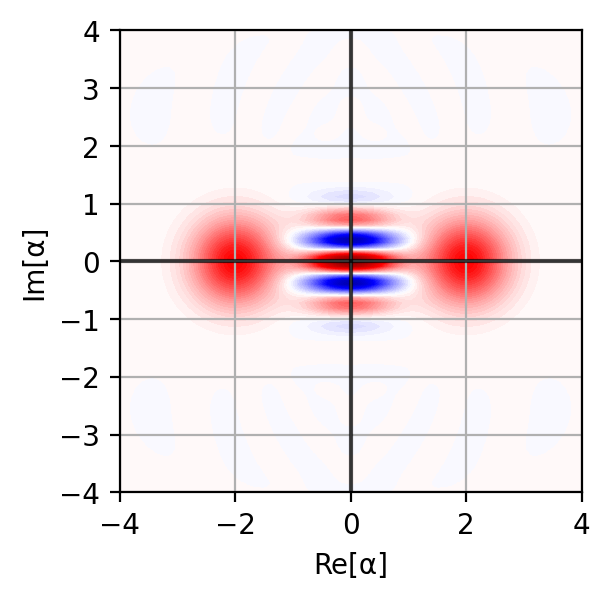

In [5]:
params = jnp.array([[0.0], [jnp.pi/2], [4]])

final_state = run_circuit(
    params
)

state = final_state
pts = jnp.linspace(-4,4, 101)
ax = jqt.plot_wigner(jqt.ptrace(state,1), pts)
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")

In [8]:
def fid_metric(params):
    N = 20
    target_state = (jqt.coherent(N,-2) + jqt.coherent(N,2)).unit()
    prepared_state = jqt.ptrace(run_circuit(params),1)
    return 1-jnp.real(jqt.overlap(target_state, prepared_state).data[0][0])

In [9]:
fid_metric(params)

Array(2.3727136e-07, dtype=float64)

# Optimize

In [10]:
metric = fid_metric 
metric_grad = grad(metric)

In [21]:
start_learning_rate = 1e-1
optimizer = optax.adam(start_learning_rate)

# Initialize parameters of the model + optimizer.
params = jnp.array([[0.0], [jnp.pi/2], [4]]) + jnp.array([[0.1], [-0.1], [-0.5]])
# params = jnp.array([[0.0], [0.0], [0]])
opt_state = optimizer.init(params)

# A simple update loop.
params_history = [params]
metric_history = [metric(params)]
for _ in tqdm(range(200)):
  metric_history.append(metric(params))
  grads = metric_grad(params)
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  params_history.append(params)

params_history = jnp.array(params_history)

100%|██████████| 200/200 [01:03<00:00,  3.17it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


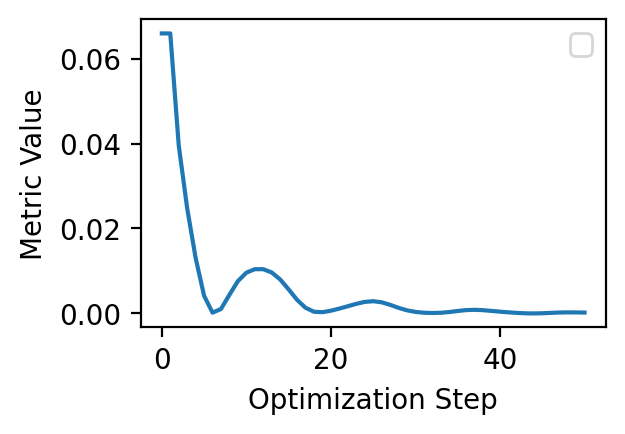

In [19]:
fig, ax = plt.subplots(1,1, dpi=200, figsize=(3,2))
ax.plot(metric_history)
ax.set_xlabel("Optimization Step")
ax.set_ylabel("Metric Value")
ax.legend()

# PPO

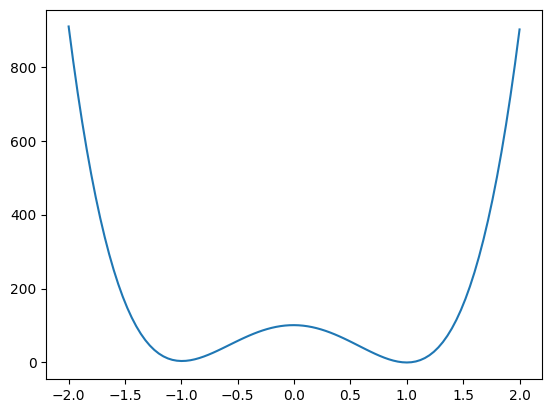

In [5]:
import matplotlib.pyplot as plt
def rosenbrock(x):
    return (1 - x)**2 + 100 * (x**2 - 1)**2

x = jnp.linspace(-2,2,101)

plt.plot(x, rosenbrock(x))

In [7]:
import jax
import jax.numpy as jnp
import optax
from jax import random, grad, jit, vmap
import numpy as np
from functools import partial

# Define the function to minimize (e.g., Rosenbrock function)
def rosenbrock(x):
    return (1 - x)**2 + 100 * (x**2 - 1)**2

# Define the gradient of the Rosenbrock function
grad_rosenbrock = jax.jit(grad(rosenbrock))

# Define the policy and value networks using JAX
def mlp(hidden_sizes, output_size=1):
    def init_fn(rng, input_shape):
        params = []
        for in_size, out_size in zip([input_shape[0]] + hidden_sizes, hidden_sizes + [output_size]):
            w_key, b_key = random.split(rng)
            w = random.normal(w_key, (in_size, out_size)) * 0.1
            b = jnp.zeros((out_size,))
            params.append((w, b))
        return params

    def apply_fn(params, x):
        for (w, b) in params[:-1]:
            x = jnp.tanh(jnp.dot(x, w) + b)  # Apply tanh for hidden layers
        w, b = params[-1]
        action_mean = jnp.dot(x, w) + b  # Mean of the action distribution
        action_log_std = jnp.zeros_like(action_mean)  # Fixed log_std for simplicity (learnable if needed)
        return action_mean, action_log_std

    return init_fn, apply_fn

# Define the environment class for function minimization
class FunctionMinimizationEnv:
    def __init__(self, bounds=(-5, 5)):
        self.bounds = bounds
        self.reset()

    def reset(self):
        # Reset the environment by sampling a random starting position
        self.position = np.random.uniform(self.bounds[0], self.bounds[1])
        return self.position

    def step(self, action):
        # Ensure the action stays within the bounds
        action = np.clip(action, self.bounds[0], self.bounds[1])
        self.position = action
        reward = -rosenbrock(action)  # Negative of the function value
        done = reward > -1e-6  # Done when function value is sufficiently small
        return self.position, reward, done

    def render(self):
        pass  # No rendering for this task

# PPO Implementation

def ppo_update(params, value_params, states, actions, rewards, old_log_probs, policy_apply_fn, value_apply_fn, clip_ratio=0.2, gamma=0.99, lam=0.95, vf_coef=0.5, entropy_coef=0.1):
    """
    Perform PPO update (policy and value network update).
    """
    # Compute the advantage estimates (Generalized Advantage Estimation)
    def compute_advantages(rewards, values, next_values, dones):
        delta = rewards + gamma * next_values * (1 - dones) - values
        adv = 0
        advantages = []
        for d in reversed(delta):
            adv = d + gamma * lam * adv
            advantages.append(adv)
        return jnp.array(advantages[::-1])

    # Get the value predictions for the current states
    values = vmap(lambda state: value_apply_fn(value_params, state))(states)
    
    # Calculate next values (e.g., bootstrap with a value function or zero for simplicity)
    next_values = np.zeros_like(values)  # For simplicity, assume zero next values
    advantages = compute_advantages(rewards, values, next_values, np.zeros_like(rewards))

    # Normalize advantages for stability
    advantages = (advantages - jnp.mean(advantages)) / (jnp.std(advantages) + 1e-8)

    # Gaussian policy log-probabilities
    def log_prob_fn(params, state, action):
        mean, log_std = policy_apply_fn(params, state)
        std = jnp.exp(log_std)
        dist = jax.scipy.stats.norm(loc=mean, scale=std)
        log_prob = dist.logpdf(action)
        return log_prob

    log_probs = vmap(lambda state, action: log_prob_fn(params, state, action))(states, actions)
    ratio = jnp.exp(log_probs - old_log_probs)

    # Clipped surrogate objective
    surrogate_loss = -jnp.mean(jnp.minimum(ratio * advantages, jnp.clip(ratio, 1 - clip_ratio, 1 + clip_ratio) * advantages))

    # Value loss
    value_loss = jnp.mean((values - rewards) ** 2)

    # Entropy regularization for exploration
    entropy = -jnp.mean(jnp.exp(log_probs) * log_probs)

    # Total loss (policy loss + value loss + entropy loss)
    total_loss = surrogate_loss + vf_coef * value_loss - entropy_coef * entropy

    return total_loss, surrogate_loss, value_loss, entropy

# Training loop
def train():
    # Create environment
    env = FunctionMinimizationEnv()

    # Initialize policy and value networks
    policy_init_fn, policy_apply_fn = mlp([64, 64], output_size=1)
    value_init_fn, value_apply_fn = mlp([64, 64])

    # Random number generator key for JAX
    key = random.PRNGKey(0)

    # Initialize parameters for policy and value networks
    policy_params = policy_init_fn(key, input_shape=(1,))
    value_params = value_init_fn(key, input_shape=(1,))

    # Define optimizers (Adam)
    policy_optimizer = optax.adam(1e-4)  # Reduced learning rate for stability
    value_optimizer = optax.adam(1e-4)   # Reduced learning rate for stability

    # Training loop (PPO)
    for step in range(10000):
        states = []
        actions = []
        rewards = []
        old_log_probs = []

        # Collect data (interact with the environment)
        state = env.reset()
        done = False
        while not done:
            state = jnp.array(state)
            action_mean, action_log_std = policy_apply_fn(policy_params, state)
            action_std = jnp.exp(action_log_std)  # Use standard deviation to sample actions
            action = action_mean + action_std * random.normal(key, shape=(1,))  # Sample action from Gaussian
            log_prob = -0.5 * ((action - action_mean) / action_std) ** 2  # Log-probability of action

            new_state, reward, done = env.step(action)
            
            print(f"Step {step}, State: {state}, Action: {action}, Reward: {reward}")
            
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            old_log_probs.append(log_prob)

            state = new_state

        states = jnp.array(states)
        actions = jnp.array(actions)
        rewards = jnp.array(rewards)
        old_log_probs = jnp.array(old_log_probs)

        # Update policy and value networks using PPO update
        total_loss, _, _, _ = ppo_update(policy_params, value_params, states, actions, rewards, old_log_probs, policy_apply_fn, value_apply_fn)
        
        # Compute gradients and apply updates
        policy_grads = jax.grad(total_loss, argnums=0)(policy_params, value_params, states, actions, rewards, old_log_probs, policy_apply_fn, value_apply_fn)
        value_grads = jax.grad(total_loss, argnums=1)(policy_params, value_params, states, actions, rewards, old_log_probs, policy_apply_fn, value_apply_fn)

        policy_params = optax.apply_updates(policy_params, policy_optimizer.update(policy_grads, policy_params)[1])
        value_params = optax.apply_updates(value_params, value_optimizer.update(value_grads, value_params)[1])

        print(f"Step {step}, Reward: {rewards.mean()}")

train()


Step 0, State: -1.626761794090271, Action: [[-0.23158503]], Reward: [[-91.07811]]
Step 0, State: [[-0.23158503]], Action: [[-0.20967802]], Reward: [[-92.86364]]
Step 0, State: [[-0.20967802]], Action: [[-0.20931576]], Reward: [[-92.891785]]
Step 0, State: [[-0.20931576]], Action: [[-0.20930977]], Reward: [[-92.89225]]
Step 0, State: [[-0.20930977]], Action: [[-0.20930968]], Reward: [[-92.892265]]
Step 0, State: [[-0.20930968]], Action: [[-0.20930967]], Reward: [[-92.892265]]
Step 0, State: [[-0.20930967]], Action: [[-0.20930967]], Reward: [[-92.892265]]
Step 0, State: [[-0.20930967]], Action: [[-0.20930967]], Reward: [[-92.892265]]
Step 0, State: [[-0.20930967]], Action: [[-0.20930967]], Reward: [[-92.892265]]
Step 0, State: [[-0.20930967]], Action: [[-0.20930967]], Reward: [[-92.892265]]
Step 0, State: [[-0.20930967]], Action: [[-0.20930967]], Reward: [[-92.892265]]
Step 0, State: [[-0.20930967]], Action: [[-0.20930967]], Reward: [[-92.892265]]
Step 0, State: [[-0.20930967]], Action: 

KeyboardInterrupt: 